In [1]:
import os.path
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

Load the data and preprocess it.

In [2]:
FILEPATH = os.path.abspath("../data/2023-03-25_22hr_29min_ptwr_data.tsv")
df = pd.read_csv(FILEPATH, sep="\t")

MAKE = "make"
MODEL = "model"
SPECS = "specs"

CLEAN_MAKE = re.compile(r"((/make/)|(\-power\-to\-weight\-ratio\-stats))")
CLEAN_MODEL = re.compile(r"(/model/)")
CLEAN_SPECS = re.compile(r"(\\t|\\n)")

df[MAKE] = df[MAKE].apply(lambda x: CLEAN_MAKE.sub("", x))
df[MODEL] = df[MODEL].apply(lambda x: CLEAN_MODEL.sub("", x))
df[SPECS] = df[SPECS].apply(lambda x: CLEAN_SPECS.sub("", x))

SEPARATOR = ":"
SPECS1 = "specs1"
df[SPECS1] = df[SPECS].apply(lambda x: float(x.split(SEPARATOR)[-1]))
df[SPECS] = df[SPECS].apply(lambda x: SEPARATOR.join((x.split(SEPARATOR)[:-1])))

print(df.describe())
print(df.head())

             specs1
count  43219.000000
mean       0.064918
std        0.029648
min        0.017000
25%        0.050000
50%        0.059000
75%        0.070000
max        0.636000
    make     model                      specs  specs1
0  acura  acura-cl         1997 Acura CL 2.2    0.047
1  acura  acura-cl         1998 Acura CL 2.3    0.049
2  acura  acura-cl  1998 Acura CL 2.3 Premium   0.049
3  acura  acura-cl         1999 Acura CL 2.3    0.049
4  acura  acura-cl         1997 Acura CL 3.0    0.062


# Introduction

The previous two objectives were meant to find an appropriate model for this third objective. What needs to be modeled is a given model year's power-to-weight ratios given only the data that came before. Here, I will explore methodologies toward that. I will explore a cumulative training set and I will explore subsets of the historical data as they relate to classification ability. The purpose of this is to develop a methodology which would work for new data, new power-to-weight ratios, in future model years to come. The model I have chosen for this task is the mean discriminator.

In [3]:
K = 2
HIGH = 1
LOW = 0
NUM_FOLDS = 7
NUM_ITERATIONS = 200

MODEL_YEAR = "model_year"
MATCH_MODEL_YEAR = re.compile(r"[0-9]{4}")
df[MODEL_YEAR] = df[SPECS].apply(lambda x: MATCH_MODEL_YEAR.match(x).group(0))
MODEL_YEARS = df[MODEL_YEAR]
print(np.sum(MODEL_YEARS == None))  # check if regex matches every row
MODEL_YEARS = MODEL_YEARS.unique()
print(MODEL_YEARS)

0
['1997' '1998' '1999' '2001' '2002' '2003' '2013' '2014' '2015' '2016'
 '2017' '2018' '2019' '2020' '2021' '2022' '1992' '2000' '1994' '1995'
 '1996' '1993' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2023' '1991' '1987' '1988' '1989' '1990' '1986' '1978']


I need to explore each model year, sorted chronologically, and how many power-to-weight ratio values are in each model year. The reason for exploring how many values are in each model year is because some model years have very few values and should probably be excluded from the experiment.

In [4]:
print(MODEL_YEARS)
MODEL_YEARS = np.sort(MODEL_YEARS)
print(MODEL_YEARS)

year_and_value_count = {x:len(df[df[MODEL_YEAR]==x]) for x in MODEL_YEARS}
print(year_and_value_count)

['1997' '1998' '1999' '2001' '2002' '2003' '2013' '2014' '2015' '2016'
 '2017' '2018' '2019' '2020' '2021' '2022' '1992' '2000' '1994' '1995'
 '1996' '1993' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2023' '1991' '1987' '1988' '1989' '1990' '1986' '1978']
['1978' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023']
{'1978': 1, '1986': 1, '1987': 2, '1988': 2, '1989': 3, '1990': 4, '1991': 5, '1992': 708, '1993': 715, '1994': 669, '1995': 670, '1996': 649, '1997': 617, '1998': 735, '1999': 770, '2000': 811, '2001': 1082, '2002': 1142, '2003': 1188, '2004': 1323, '2005': 1369, '2006': 1430, '2007': 1481, '2008': 1500, '2009': 1554, '2010': 1416, '2011': 1495, '2012': 1576, '2013': 1861, '2014': 1928, '2015': 1950, '2016': 1448, '2017': 1467, '2018': 222

The cutoff should be model year 1991 (index 6), anything on or before 1991 should not be included. Additionally, 2023 (last element) should not be included.

In [5]:
MODEL_YEARS = MODEL_YEARS[7:-1]
print(MODEL_YEARS)

['1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001'
 '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021'
 '2022']


In [6]:
def mean_inference(df, mean):
    result = df.apply(lambda x: HIGH if x > mean else LOW)
    return result

# Ground truth within model year of interest only (not global)

In [7]:
metrics_by_model_year = {}
for idx, year in enumerate(MODEL_YEARS):
    if idx == 0:
        continue
    df2 = df[df[MODEL_YEAR].isin(MODEL_YEARS[:idx])]  # previous model years
    df3 = df[df[MODEL_YEAR] == MODEL_YEARS[idx]]  # current model year
    LENGTH = len(df3)

    mean_reference = mean_inference(df3[SPECS1], np.mean(df3[SPECS1]))  # ground truth with respect to model year, not global

    test = df3
    train_values = df2[SPECS1]

    mean = np.mean(train_values)
    test_inferred = mean_inference(test[SPECS1], mean)
    mean_reference_test_view = mean_reference

    # positive class is HIGH
    tp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == HIGH])
    tn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == LOW])
    fp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == HIGH])
    fn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == LOW])

    metrics_by_model_year[year] = [tp, tn, fp, fn]

for year, metric in metrics_by_model_year.items():
    metrics_by_model_year[year] = (metric[0]+metric[1])/np.sum(metric)
print(np.mean(list(metrics_by_model_year.values())))
print(np.std(list(metrics_by_model_year.values())))

0.848631061826751
0.06781039699788692


# Ground truth against global (up until that model year)

In [8]:
metrics_by_model_year = {}
for idx, year in enumerate(MODEL_YEARS):
    if idx == 0:
        continue
    df2 = df[df[MODEL_YEAR].isin(MODEL_YEARS[:idx])]  # previous model years
    df3 = df[df[MODEL_YEAR] == MODEL_YEARS[idx]]  # current model year
    df4 = df[df[MODEL_YEAR].isin(MODEL_YEARS[:idx+1])]  # completely cumulative

    mean_reference = mean_inference(df4[SPECS1], np.mean(df4[SPECS1]))  # ground truth with respect to all applicable model years

    test = df3
    train_values = df2[SPECS1]

    mean = np.mean(train_values)
    test_inferred = mean_inference(test[SPECS1], mean)
    mean_reference_test_view = mean_reference[mean_reference.index.isin(test.index)]

    # positive class is HIGH
    tp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == HIGH])
    tn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == LOW])
    fp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == HIGH])
    fn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == LOW])

    metrics_by_model_year[year] = [tp, tn, fp, fn]

for year, metric in metrics_by_model_year.items():
    metrics_by_model_year[year] = (metric[0]+metric[1])/np.sum(metric)
print(np.mean(list(metrics_by_model_year.values())))
print(np.std(list(metrics_by_model_year.values())))

0.983958912593263
0.016670202430817


With respect to the question "Is this power-to-weight ratio high or low?", and given historical data, the mean discriminator seems reasonable. With respect to the question "Is this power-to-weight ratio hig or low, for this model year?", even given historical data that may still be a difficult question to answer. Next, I am going to see if I can determine if adding a bias term to the mean can positively affect this 'per-model-year' designation.

# Dependent Bias: Ground truth within model year only (not global)

I am going to try and find a function f(t)=bt, where b is a constant, that maps model year (t=0 at the oldest model year) to an appropriate bias to help classify a given next model year with respect to answering the question "Is this power-to-weight ratio high or low, for this model year?".

In [9]:
def bias_function_linear(t, b, c):
    return (b*t)+c

In [10]:
def bias_function_scalar(c):
    return c

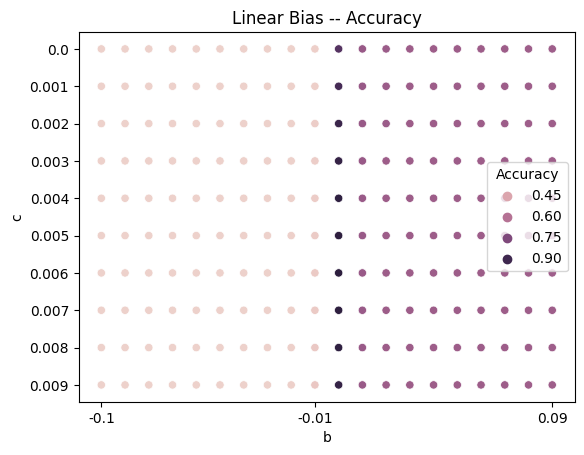

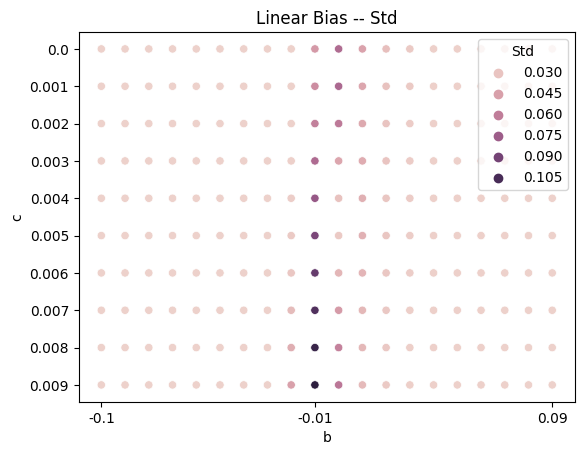

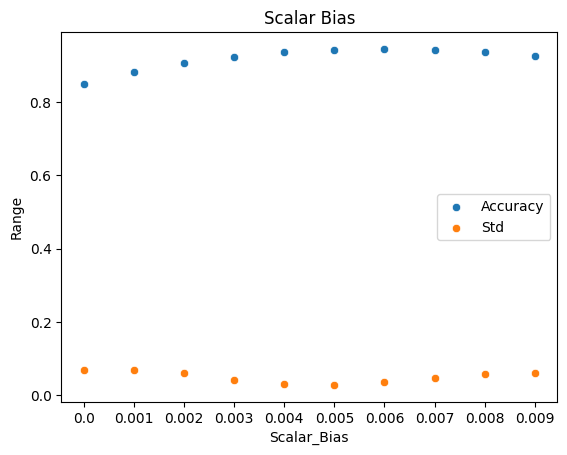

In [11]:
BIAS_UPPER_LIMIT_TERM = 10
BIAS_LOWER_LIMIT_TERM = -10
BIAS_SCALER_TERM = 100

BIAS_UPPER_LIMIT_OFFSET = 10
BIAS_LOWER_LIMIT_OFFSET = 0
BIAS_SCALER_OFFSET = 1000
# The above tuned by hand

metrics_by_bias_linear = {}
metrics_by_bias_scalar = {}
for c in range(BIAS_LOWER_LIMIT_OFFSET,BIAS_UPPER_LIMIT_OFFSET):
    c = c/BIAS_SCALER_OFFSET
    metrics_by_model_year_linear = {}
    metrics_by_model_year_scalar = {}
    for idx, year in enumerate(MODEL_YEARS):
        if idx == 0:
            continue
        df2 = df[df[MODEL_YEAR].isin(MODEL_YEARS[:idx])]  # previous model years
        df3 = df[df[MODEL_YEAR] == MODEL_YEARS[idx]]  # current model year
        LENGTH = len(df3)

        mean_reference = mean_inference(df3[SPECS1], np.mean(df3[SPECS1]))  # ground truth with respect to model year, not global

        test = df3
        train_values = df2[SPECS1]
        mean_reference_test_view = mean_reference

        # LINEAR
        for b in range(BIAS_LOWER_LIMIT_TERM,BIAS_UPPER_LIMIT_TERM):
            b = b/BIAS_SCALER_TERM
            mean_linear = np.mean(train_values) + bias_function_linear(idx,b,c)  # linear bias
            test_inferred_linear = mean_inference(test[SPECS1], mean_linear)
    
            # positive class is HIGH
            tp_linear = np.sum([True for x,y in zip(test_inferred_linear,mean_reference_test_view) if x == y and x == HIGH])
            tn_linear = np.sum([True for x,y in zip(test_inferred_linear,mean_reference_test_view) if x == y and x == LOW])
            fp_linear = np.sum([True for x,y in zip(test_inferred_linear,mean_reference_test_view) if x != y and x == HIGH])
            fn_linear = np.sum([True for x,y in zip(test_inferred_linear,mean_reference_test_view) if x != y and x == LOW])

            if str(b) not in metrics_by_model_year_linear:
                metrics_by_model_year_linear[str(b)] = {}
            metrics_by_model_year_linear[str(b)][year] = [tp_linear, tn_linear, fp_linear, fn_linear]

        # SCALAR
        mean_scalar = np.mean(train_values) + bias_function_scalar(c)  # scalar bias
        test_inferred_scalar = mean_inference(test[SPECS1], mean_scalar)

        # positive class is HIGH
        tp_scalar = np.sum([True for x,y in zip(test_inferred_scalar,mean_reference_test_view) if x == y and x == HIGH])
        tn_scalar = np.sum([True for x,y in zip(test_inferred_scalar,mean_reference_test_view) if x == y and x == LOW])
        fp_scalar = np.sum([True for x,y in zip(test_inferred_scalar,mean_reference_test_view) if x != y and x == HIGH])
        fn_scalar = np.sum([True for x,y in zip(test_inferred_scalar,mean_reference_test_view) if x != y and x == LOW])

        metrics_by_model_year_scalar[year] = [tp_scalar, tn_scalar, fp_scalar, fn_scalar]
    
    metrics_by_bias_linear[str(c)] = metrics_by_model_year_linear
    metrics_by_bias_scalar[str(c)] = metrics_by_model_year_scalar

linear_metric_data_for_plot = []
for c, metrics in metrics_by_bias_linear.items():
    for b,metric in metrics.items():
        accuracies = []
        for year,val in metric.items():
            accuracies.append((val[0]+val[1])/np.sum(val))
        mean_accuracies_overall = np.mean(accuracies)
        mean_std_overall = np.std(accuracies)
        linear_metric_data_for_plot.append((b,c,mean_accuracies_overall,mean_std_overall))
df_plot_linear = pd.DataFrame(linear_metric_data_for_plot, columns=["Linear_Term", "Linear_Offset", "Accuracy", "Std"])

fig0, ax0 = plt.subplots()
plt.xticks([0,np.floor((np.abs(BIAS_LOWER_LIMIT_TERM)+BIAS_UPPER_LIMIT_TERM-1)/2),np.abs(BIAS_LOWER_LIMIT_TERM)+BIAS_UPPER_LIMIT_TERM-1])
plt.ylabel("c")
plt.xlabel("b")
plt.title("Linear Bias -- Accuracy")
sns.scatterplot(df_plot_linear, x="Linear_Term", y="Linear_Offset", hue="Accuracy", ax=ax0)

fig1, ax1 = plt.subplots()
plt.xticks([0,np.floor((np.abs(BIAS_LOWER_LIMIT_TERM)+BIAS_UPPER_LIMIT_TERM-1)/2),np.abs(BIAS_LOWER_LIMIT_TERM)+BIAS_UPPER_LIMIT_TERM-1])
plt.ylabel("c")
plt.xlabel("b")
plt.title("Linear Bias -- Std")
sns.scatterplot(df_plot_linear, x="Linear_Term", y="Linear_Offset", hue="Std", ax=ax1)

scalar_metric_data_for_plot = []
for c, metrics in metrics_by_bias_scalar.items():
    accuracies = []
    for year, metric in metrics.items():
        accuracies.append((metric[0]+metric[1])/np.sum(metric))
    mean_accuracies_overall = np.mean(accuracies)
    mean_std_overall = np.std(accuracies)
    scalar_metric_data_for_plot.append((c, mean_accuracies_overall, mean_std_overall))
df_plot_scalar = pd.DataFrame(scalar_metric_data_for_plot, columns=["Scalar_Bias", "Accuracy", "Std"])

fig2, ax2 = plt.subplots()
# plt.xticks([0,np.floor(BIAS_UPPER_LIMIT_OFFSET/2),BIAS_UPPER_LIMIT_OFFSET-1])
plt.ylabel("Range")
plt.legend("Accuracy")
plt.title("Scalar Bias")
sns.scatterplot(df_plot_scalar, x="Scalar_Bias", y="Accuracy", ax=ax2, label="Accuracy")
sns.scatterplot(df_plot_scalar, x="Scalar_Bias", y="Std", ax=ax2, label="Std")

plt.show()

# Trying Scalar Bias

I'm going to try a scalar term of 0.005, by inspection, for the ground truth within model year.

In [12]:
B = 0
C = 0.005

metrics_by_model_year = {}
for idx, year in enumerate(MODEL_YEARS):
    if idx == 0:
        continue
    df2 = df[df[MODEL_YEAR].isin(MODEL_YEARS[:idx])]  # previous model years
    df3 = df[df[MODEL_YEAR] == MODEL_YEARS[idx]]  # current model year
    LENGTH = len(df3)

    mean_reference = mean_inference(df3[SPECS1], np.mean(df3[SPECS1]))  # ground truth with respect to model year, not global

    test = df3
    train_values = df2[SPECS1]

    # mean = np.mean(train_values) + bias_function_scalar(C)
    mean = np.mean(train_values) + bias_function_linear(idx,B,C)
    test_inferred = mean_inference(test[SPECS1], mean)
    mean_reference_test_view = mean_reference

    # positive class is HIGH
    tp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == HIGH])
    tn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == LOW])
    fp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == HIGH])
    fn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == LOW])

    metrics_by_model_year[year] = [tp, tn, fp, fn]

for year, metric in metrics_by_model_year.items():
    metrics_by_model_year[year] = (metric[0]+metric[1])/np.sum(metric)
print(np.mean(list(metrics_by_model_year.values())))
print(np.std(list(metrics_by_model_year.values())))

0.9425347438371309
0.028536637118196317


# Discussion: Mean discriminator